In [24]:
import os
import random
import shutil

# Directories for HGG and LGG slices
hgg_dir = '/kaggle/input/brats2020-hgg-lgg/BraTS2020_HGG-LGG/BraTS2020_TrainingData/HGG'
lgg_dir = '/kaggle/input/brats2020-hgg-lgg/BraTS2020_HGG-LGG/BraTS2020_TrainingData/LGG'

# Creating Dataset 

In [57]:
new_hgg_dir = '/kaggle/working/HGG_80_files' 

os.makedirs(new_hgg_dir, exist_ok=True)
all_patient_folders = [folder for folder in os.listdir(hgg_dir) if os.path.isdir(os.path.join(hgg_dir, folder))]
selected_patient_folders = all_patient_folders[:80]

for folder in selected_patient_folders:
    full_folder_path = os.path.join(hgg_dir, folder)
    destination_folder_path = os.path.join(new_hgg_dir, folder)
    shutil.copytree(full_folder_path, destination_folder_path)

print(f'Copied {len(selected_patient_folders)} patient folders to {new_hgg_dir}')

# fusing of T2 , flair and tice 


In [25]:
import os
import nibabel as nib
import numpy as np

def load_nii_image(file_path):
    img = nib.load(file_path)
    img_data = img.get_fdata()
    return img_data

def preprocess_and_fuse_patient_images(patient_folder):
    flair_path = os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_flair.nii")
    t1ce_path = os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_t1ce.nii")
    t2_path = os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_t2.nii")
    
    flair_img = load_nii_image(flair_path)
    t1ce_img = load_nii_image(t1ce_path)
    t2_img = load_nii_image(t2_path)
    
    flair_slice = get_central_slice(flair_img)
    t1ce_slice = get_central_slice(t1ce_img)
    t2_slice = get_central_slice(t2_img)
    
    fused_image = np.stack([
        preprocess_slice(flair_slice), 
        preprocess_slice(t1ce_slice), 
        preprocess_slice(t2_slice)
    ], axis=-1)
    
    return fused_image

def get_central_slice(img_data):

    z_center = img_data.shape[2] // 2
    central_slice = img_data[:, :, z_center]
    return central_slice

def preprocess_slice(slice_data):
    normalized_slice = (slice_data / np.max(slice_data)) * 255
    return normalized_slice.astype(np.uint8)


In [26]:
def load_and_preprocess_grade_folder(grade_folder, label):
    images = []
    labels = []
    
    for patient_folder in os.listdir(grade_folder):
        patient_folder_path = os.path.join(grade_folder, patient_folder)
        if os.path.isdir(patient_folder_path):
            fused_image = preprocess_and_fuse_patient_images(patient_folder_path)
            images.append(fused_image)
            labels.append(label)
    
    return np.array(images), np.array(labels)

hgg_folder_path = "/kaggle/working/HGG_80_files"
lgg_folder_path = "/kaggle/input/brats2020-hgg-lgg/BraTS2020_HGG-LGG/BraTS2020_TrainingData/LGG"

hgg_images, hgg_labels = load_and_preprocess_grade_folder(hgg_folder_path, label=1)
lgg_images, lgg_labels = load_and_preprocess_grade_folder(lgg_folder_path, label=0)


# Visualization

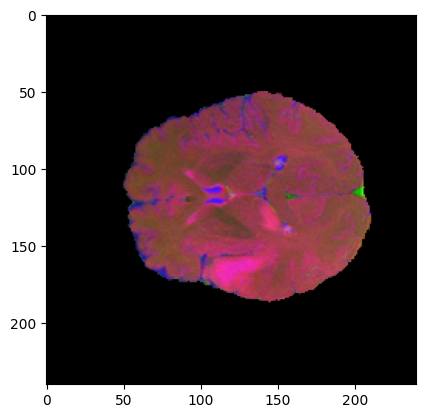

In [59]:
import matplotlib.pyplot as plt

plt.imshow(hgg_images[0])

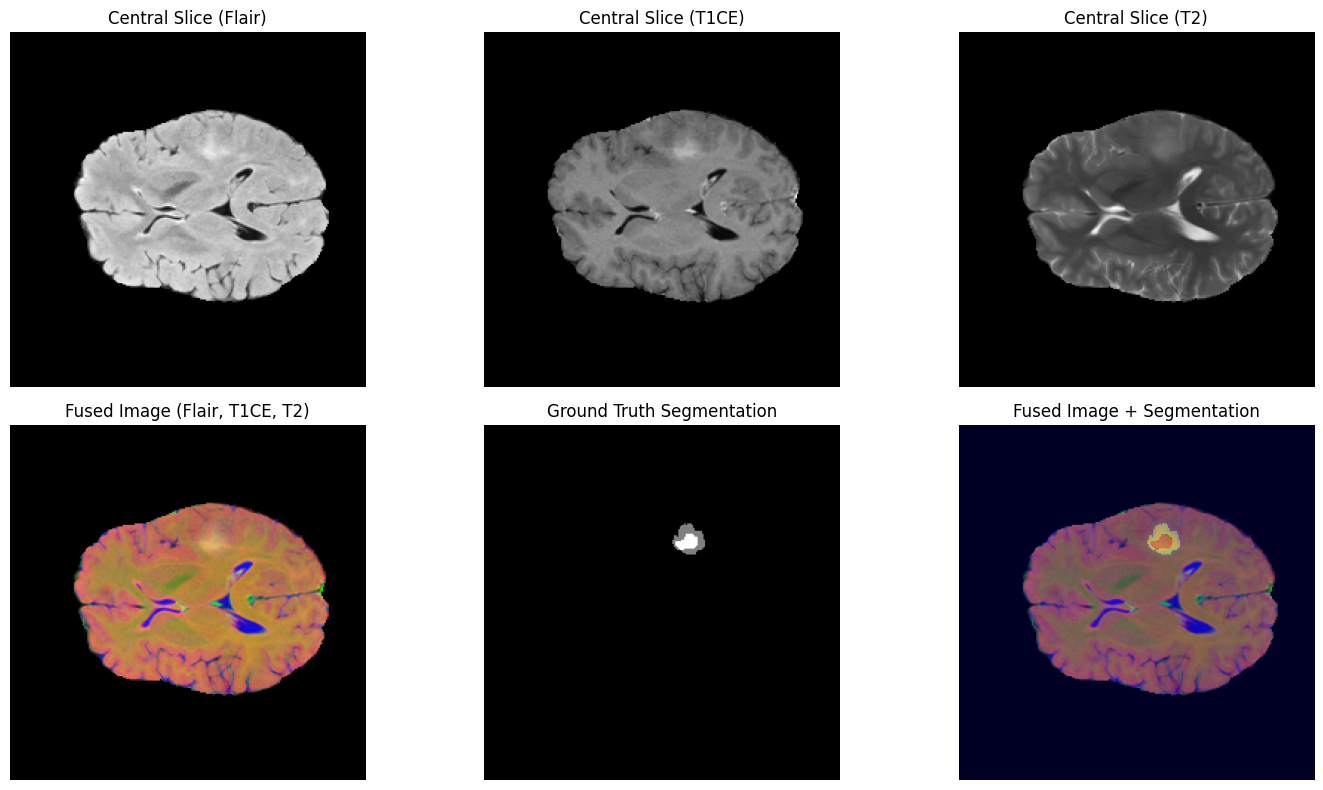

In [29]:
def preprocess_and_fuse_patient_images(patient_folder):
    # File paths for the 5 modalities (Flair, T1CE, T2, Segmentation)
    flair_path = os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_flair.nii")
    t1ce_path = os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_t1ce.nii")
    t2_path = os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_t2.nii")
    seg_path = os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_seg.nii")
    
    flair_img = load_nii_image(flair_path)
    t1ce_img = load_nii_image(t1ce_path)
    t2_img = load_nii_image(t2_path)
    segmentation_mask = load_nii_image(seg_path)

    flair_slice = get_central_slice(flair_img)
    t1ce_slice = get_central_slice(t1ce_img)
    t2_slice = get_central_slice(t2_img)
    ground_truth_slice = get_central_slice(segmentation_mask)

    flair_slice = preprocess_slice(flair_slice)
    t1ce_slice = preprocess_slice(t1ce_slice)
    t2_slice = preprocess_slice(t2_slice)

    fused_image = np.stack([flair_slice, t1ce_slice, t2_slice], axis=-1)

    return fused_image, flair_slice, t1ce_slice, t2_slice, ground_truth_slice

# Function to plot the images
def plot_images(fused_image, flair_slice, t1ce_slice, t2_slice, ground_truth_slice):
    plt.figure(figsize=(15, 8))


    plt.subplot(2, 3, 4)
    plt.imshow(fused_image)
    plt.title("Fused Image (Flair, T1CE, T2)")
    plt.axis("off")

    plt.subplot(2, 3, 1)
    plt.imshow(flair_slice, cmap="gray")
    plt.title("Central Slice (Flair)")
    plt.axis("off")

    plt.subplot(2, 3, 2)
    plt.imshow(t1ce_slice, cmap="gray")
    plt.title("Central Slice (T1CE)")
    plt.axis("off")

    plt.subplot(2, 3, 3)
    plt.imshow(t2_slice, cmap="gray")
    plt.title("Central Slice (T2)")
    plt.axis("off")

    plt.subplot(2, 3, 5)
    plt.imshow(ground_truth_slice, cmap="gray")
    plt.title("Ground Truth Segmentation")
    plt.axis("off")

    plt.subplot(2, 3, 6)
    plt.imshow(fused_image)
    plt.imshow(ground_truth_slice, cmap="jet", alpha=0.3)
    plt.title("Fused Image + Segmentation")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
patient_folder = "/kaggle/working/HGG_80_files/BraTS20_Training_209"  
fused_image, flair_slice, t1ce_slice, t2_slice, ground_truth_slice = preprocess_and_fuse_patient_images(patient_folder)
plot_images(fused_image, flair_slice, t1ce_slice, t2_slice, ground_truth_slice)

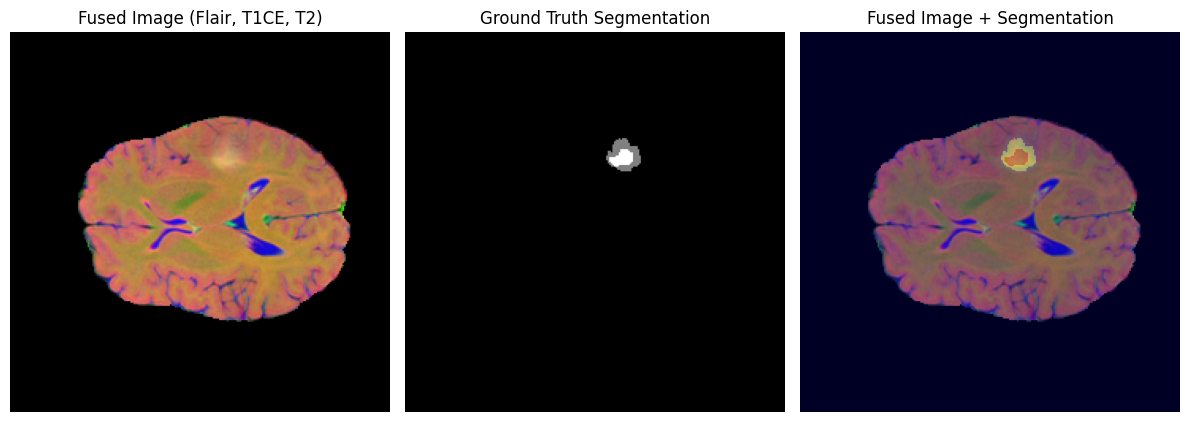

In [28]:

def preprocess_and_fuse_patient_images(patient_folder):
    flair_path = os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_flair.nii")
    t1ce_path = os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_t1ce.nii")
    t2_path = os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_t2.nii")
    seg_path = os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_seg.nii")
    
    flair_img = load_nii_image(flair_path)
    t1ce_img = load_nii_image(t1ce_path)
    t2_img = load_nii_image(t2_path)
    segmentation_mask = load_nii_image(seg_path)

    flair_slice = get_central_slice(flair_img)
    t1ce_slice = get_central_slice(t1ce_img)
    t2_slice = get_central_slice(t2_img)
    ground_truth_slice = get_central_slice(segmentation_mask)

    fused_image = np.stack([
        preprocess_slice(flair_slice), 
        preprocess_slice(t1ce_slice), 
        preprocess_slice(t2_slice)
    ], axis=-1)
    
    return fused_image, ground_truth_slice

def plot_images(fused_image, ground_truth_slice):
    plt.figure(figsize=(12, 6))

    # Fused Image
    plt.subplot(1, 3, 1)
    plt.imshow(fused_image)
    plt.title("Fused Image (Flair, T1CE, T2)")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth_slice, cmap="gray")
    plt.title("Ground Truth Segmentation")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(fused_image)
    plt.imshow(ground_truth_slice, cmap="jet", alpha=0.3)
    plt.title("Fused Image + Segmentation")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

patient_folder = "/kaggle/working/HGG_80_files/BraTS20_Training_209"
fused_image, ground_truth_slice = preprocess_and_fuse_patient_images(patient_folder)
plot_images(fused_image, ground_truth_slice)

# CNN model

In [33]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import RMSprop

# Function to create the CNN model
def create_model(input_shape):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(240, 240, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

input_shape = (224, 224, 3)

model = create_model(input_shape)

model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.3)

X_train = np.array(X_train)
X_val = np.array(X_val)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (109, 240, 240, 3)
Validation data shape: (47, 240, 240, 3)


In [48]:

history = model.fit(X_train, y_train, epochs=15, batch_size=8)
model.save("glioma_model.h5")
val_loss, val_accuracy = model.evaluate(X_val, y_val)


Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 600ms/step - accuracy: 0.5602 - loss: 887.9706
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 544ms/step - accuracy: 0.7798 - loss: 7.7479
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 541ms/step - accuracy: 0.6784 - loss: 3.1982
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 545ms/step - accuracy: 0.9627 - loss: 0.1750
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 575ms/step - accuracy: 0.9379 - loss: 0.2783
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 544ms/step - accuracy: 0.9872 - loss: 0.0609
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 548ms/step - accuracy: 0.9717 - loss: 0.2387
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 593ms/step - accuracy: 0.8099 - loss: 5.1056
Epoch 9/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 546ms/step - accuracy: 0.9656 - loss: 0.2299
Epoch 10/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 543ms/step - accuracy: 1.0000 - loss: 0.0033
Epoch 11/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 548ms/step - accuracy: 1.0000 - loss: 7.4888e-05
Epoch 12/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s

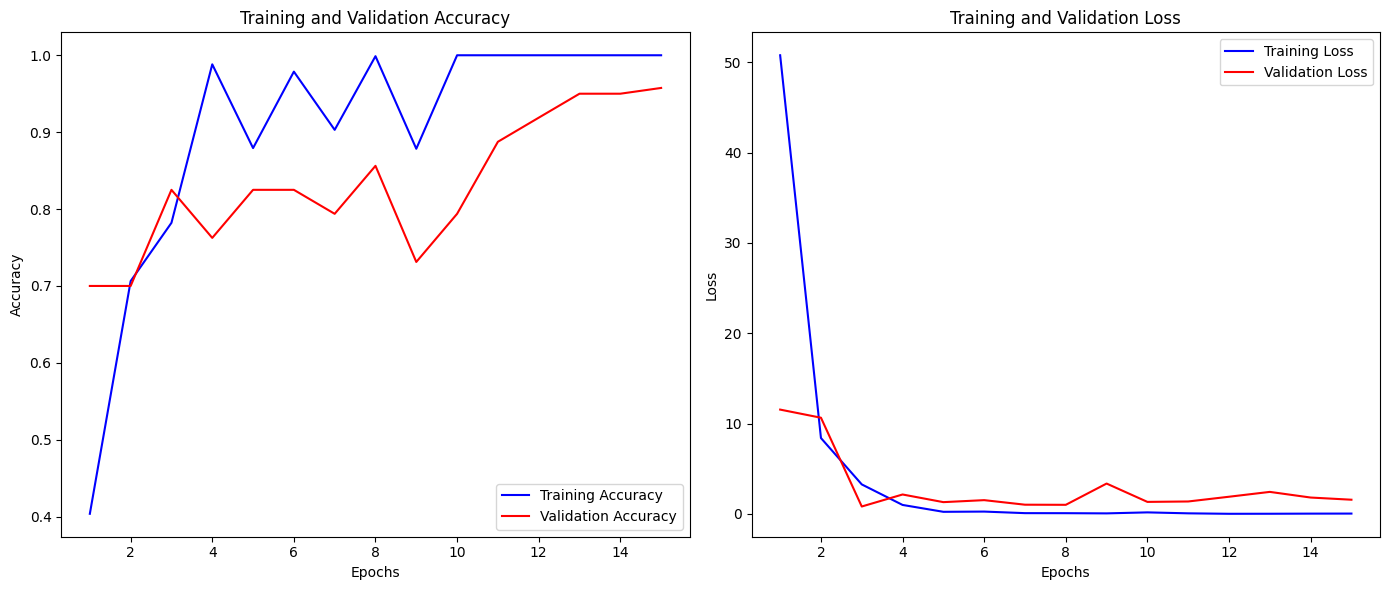

In [66]:
epochs = range(1, 16)
plt.figure(figsize=(14, 6))


plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# SEGMENTATION 

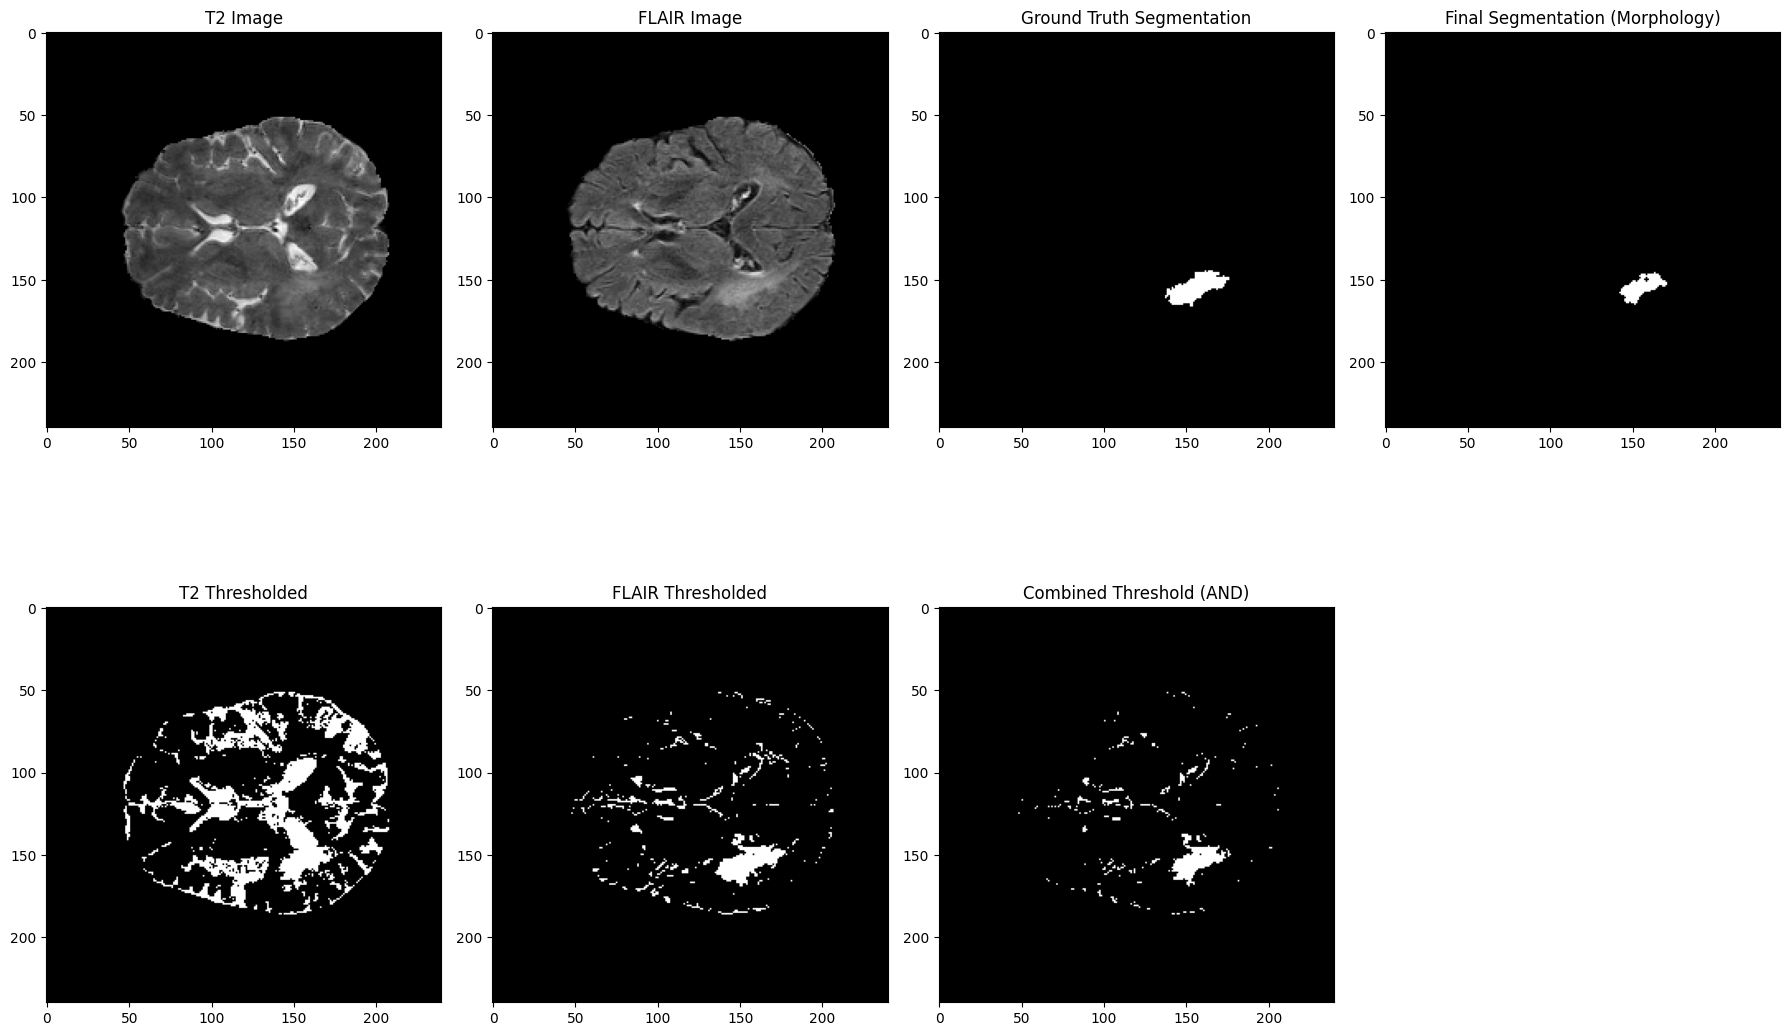

In [56]:
import nibabel as nib
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_nii_image(image_path):
    nii_image = nib.load(image_path)
    image_data = nii_image.get_fdata()
    image_data = (image_data / np.max(image_data)) * 255
    image_data = image_data.astype(np.uint8)
    return image_data

def compute_histogram(image):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    return hist

def find_global_maximum(hist):
    global_max_idx = np.argmax(hist)
    return global_max_idx

def compute_avg_gray_levels(image_t2, image_flair):
    avg_t2 = np.mean(image_t2)
    avg_flair = np.mean(image_flair)
    avg_t2_flair = (avg_t2 + avg_flair) / 2
    return avg_t2, avg_flair, avg_t2_flair

def calculate_adaptive_threshold(avgmin, avgmax, ec_min, ec_max, avg_t2_flair, global_max_t2, global_max_flair):
    c = avgmax * ec_max + avgmin * ec_min
    S = c / avg_t2_flair
    threshold_t2 = global_max_t2 + S
    threshold_flair = global_max_flair + S
    return threshold_t2, threshold_flair

def apply_threshold(image, threshold_value):
    _, thresholded_img = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
    return thresholded_img

def logical_and_operation(t2_thresh, flair_thresh):
    combined = cv2.bitwise_and(t2_thresh, flair_thresh)
    return combined

def apply_morphological_operations(image, erosion_steps=2, dilation_steps=5):
    cross_shape = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    eroded_img = cv2.erode(image, cross_shape, iterations=erosion_steps)
    dilated_img = cv2.dilate(eroded_img, cross_shape, iterations=dilation_steps)
    return dilated_img

def segment_tumor(t2_image_path, flair_image_path, seg_image_path, ec_min=50, ec_max=30, erosion_steps=2, dilation_steps=5):
    t2_image = load_nii_image(t2_image_path)
    flair_image = load_nii_image(flair_image_path)
    seg_image = load_nii_image(seg_image_path) 
    
    t2_hist = compute_histogram(t2_image)
    flair_hist = compute_histogram(flair_image)

    global_max_t2 = find_global_maximum(t2_hist)
    global_max_flair = find_global_maximum(flair_hist)
    
    avg_t2, avg_flair, avg_t2_flair = compute_avg_gray_levels(t2_image, flair_image)
    
    avgmin = min(avg_t2, avg_flair)
    avgmax = max(avg_t2, avg_flair)
    
    threshold_t2, threshold_flair = calculate_adaptive_threshold(avgmin, avgmax, ec_min, ec_max, avg_t2_flair, global_max_t2, global_max_flair)
    
    t2_thresholded_img = apply_threshold(t2_image, threshold_t2)
    flair_thresholded_img = apply_threshold(flair_image, threshold_flair)
    
    combined_thresholded_img = logical_and_operation(t2_thresholded_img, flair_thresholded_img)
    
    final_segmentation = apply_morphological_operations(combined_thresholded_img, erosion_steps, dilation_steps)
    
    # Display results
    plt.figure(figsize=(18, 12))
    
    plt.subplot(2, 4, 1)
    plt.title("T2 Image")
    plt.imshow(t2_image[:, :, t2_image.shape[2] // 2], cmap='gray')  
    
    plt.subplot(2, 4, 2)
    plt.title("FLAIR Image")
    plt.imshow(flair_image[:, :, flair_image.shape[2] // 2], cmap='gray')  
    
    plt.subplot(2, 4, 3)
    plt.title("Ground Truth Segmentation")
    plt.imshow(seg_image[:, :, seg_image.shape[2] // 2], cmap='gray') 
    
    plt.subplot(2, 4, 4)
    plt.title("Final Segmentation (Morphology)")
    plt.imshow(final_segmentation[:, :, final_segmentation.shape[2] // 2], cmap='gray')
    
    plt.subplot(2, 4, 5)
    plt.title("T2 Thresholded")
    plt.imshow(t2_thresholded_img[:, :, t2_thresholded_img.shape[2] // 2], cmap='gray')
    
    plt.subplot(2, 4, 6)
    plt.title("FLAIR Thresholded")
    plt.imshow(flair_thresholded_img[:, :, flair_thresholded_img.shape[2] // 2], cmap='gray')
    
    plt.subplot(2, 4, 7)
    plt.title("Combined Threshold (AND)")
    plt.imshow(combined_thresholded_img[:, :, combined_thresholded_img.shape[2] // 2], cmap='gray')
    
    plt.tight_layout()
    plt.show()

# Run the segmentation process using T2, FLAIR, and Ground Truth segmentation images
t2_image_path = '/kaggle/input/brats2020-hgg-lgg/BraTS2020_HGG-LGG/BraTS2020_TrainingData/HGG/BraTS20_Training_007/BraTS20_Training_007_t2.nii'    # Replace with actual T2 image path
flair_image_path = '/kaggle/input/brats2020-hgg-lgg/BraTS2020_HGG-LGG/BraTS2020_TrainingData/HGG/BraTS20_Training_007/BraTS20_Training_007_flair.nii'  # Replace with actual FLAIR image path
seg_image_path = '/kaggle/input/brats2020-hgg-lgg/BraTS2020_HGG-LGG/BraTS2020_TrainingData/HGG/BraTS20_Training_007/BraTS20_Training_007_seg.nii'  # Ground Truth segmentation

segment_tumor(t2_image_path, flair_image_path, seg_image_path, ec_min=50, ec_max=30, erosion_steps=2, dilation_steps=1)
